# Part 3.1: Zero-Shot Image Classification with CLIP

This notebook demonstrates zero-shot image classification using OpenAI's CLIP model. We'll use CLIP to classify images without any training on the specific classes, by leveraging the model's understanding of natural language descriptions.

## Installing Dependencies
We need to install CLIP and related libraries for processing images and displaying results.

In [3]:
# Install required libraries
!pip install clip-by-openai pillow numpy matplotlib torch torchvision

  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl.metadata (407 bytes)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.4-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.3-py3-none-any.whl.metadata (8.7 kB)
  Using cached clip_by_openai-0.1.1.2-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.1-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.0-py3-none-any.whl.metadata (9.0 kB)
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1

## Import Libraries and Check Device
Importing all necessary libraries and checking if GPU is available for faster inference.

In [4]:
# Import necessary libraries
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Install CLIP correctly
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zlc3lu_z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zlc3lu_z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


## Load CLIP Model
We load the ViT-B/32 CLIP model which provides a good balance between performance and speed.

In [6]:
# Load CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", device=device)
print("CLIP model loaded successfully")

CLIP model loaded successfully


## Create Test Image
Since the online image didn't load, we create a simple red image to demonstrate CLIP's zero-shot classification.

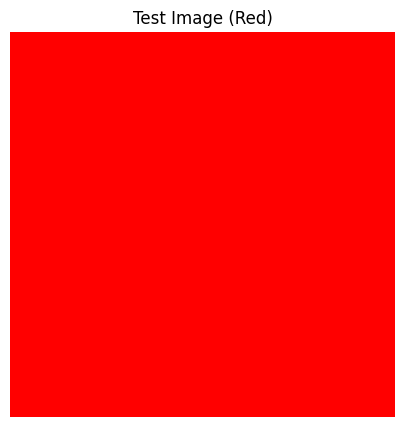

In [7]:
# Let's create a simple sample image for demonstration instead
# We'll create a simple colored image to demonstrate the classification

# Create a simple red image (representing a stop sign or apple)
width, height = 300, 300
image = Image.new('RGB', (width, height), color='red')

# Preprocess image
image_input = preprocess(image).unsqueeze(0).to(device)

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.title("Test Image (Red)")
plt.show()

## Perform Zero-Shot Classification
We define text labels describing various objects and use CLIP to compute similarity between the image and text, performing classification without any training.

In [8]:
# Define text labels for zero-shot classification
text_labels = ["a photo of a dog", "a photo of a cat", "a red object", "a blue object",
              "a photo of a car", "a stop sign", "an apple", "a red background"]

# Tokenize the text labels
text = clip.tokenize(text_labels).to(device)

# Perform zero-shot classification
with torch.no_grad():
   # Get image and text features
   image_features = model.encode_image(image_input)
   text_features = model.encode_text(text)

   # Normalize features
   image_features /= image_features.norm(dim=-1, keepdim=True)
   text_features /= text_features.norm(dim=-1, keepdim=True)

   # Calculate similarity scores
   similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
   values, indices = similarity[0].topk(5)

# Display results
print("Predicted labels and their probabilities:")
for value, index in zip(values, indices):
   print(f"{text_labels[index]:20s}: {100 * value.item():.1f}%")

Predicted labels and their probabilities:
a red background    : 77.2%
a red object        : 22.5%
a stop sign         : 0.1%
a photo of a car    : 0.1%
a photo of a dog    : 0.1%


## Visualize Zero-Shot Results
Create a horizontal bar chart showing the top 5 predictions with their confidence scores for better visualization.

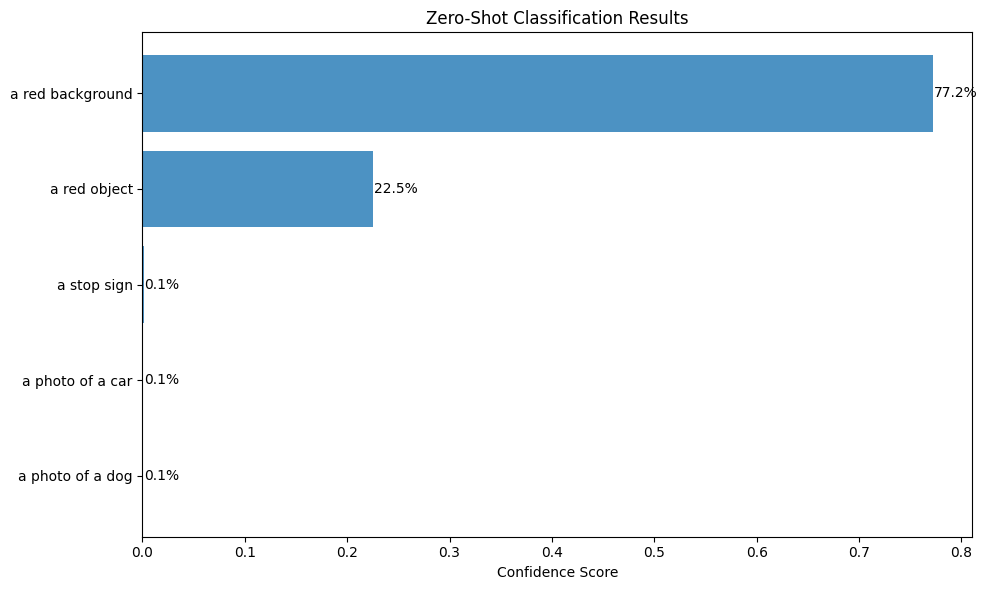

In [9]:
# Visualize the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Create bar chart
y_pos = np.arange(len(indices))
ax.barh(y_pos, [v.item() for v in values], align='center', alpha=0.8)

# Set labels
ax.set_yticks(y_pos)
ax.set_yticklabels([text_labels[i] for i in indices])
ax.invert_yaxis()  # Labels read top-to-bottom
ax.set_xlabel('Confidence Score')
ax.set_title('Zero-Shot Classification Results')

# Add percentage labels
for i, v in enumerate(values):
   ax.text(v.item() + 0.001, i, f'{100 * v.item():.1f}%', va='center')

plt.tight_layout()
plt.show()

## Test Zero-Shot on Multiple Colors
Demonstrate CLIP's ability to classify different colored images without any training on these specific examples.

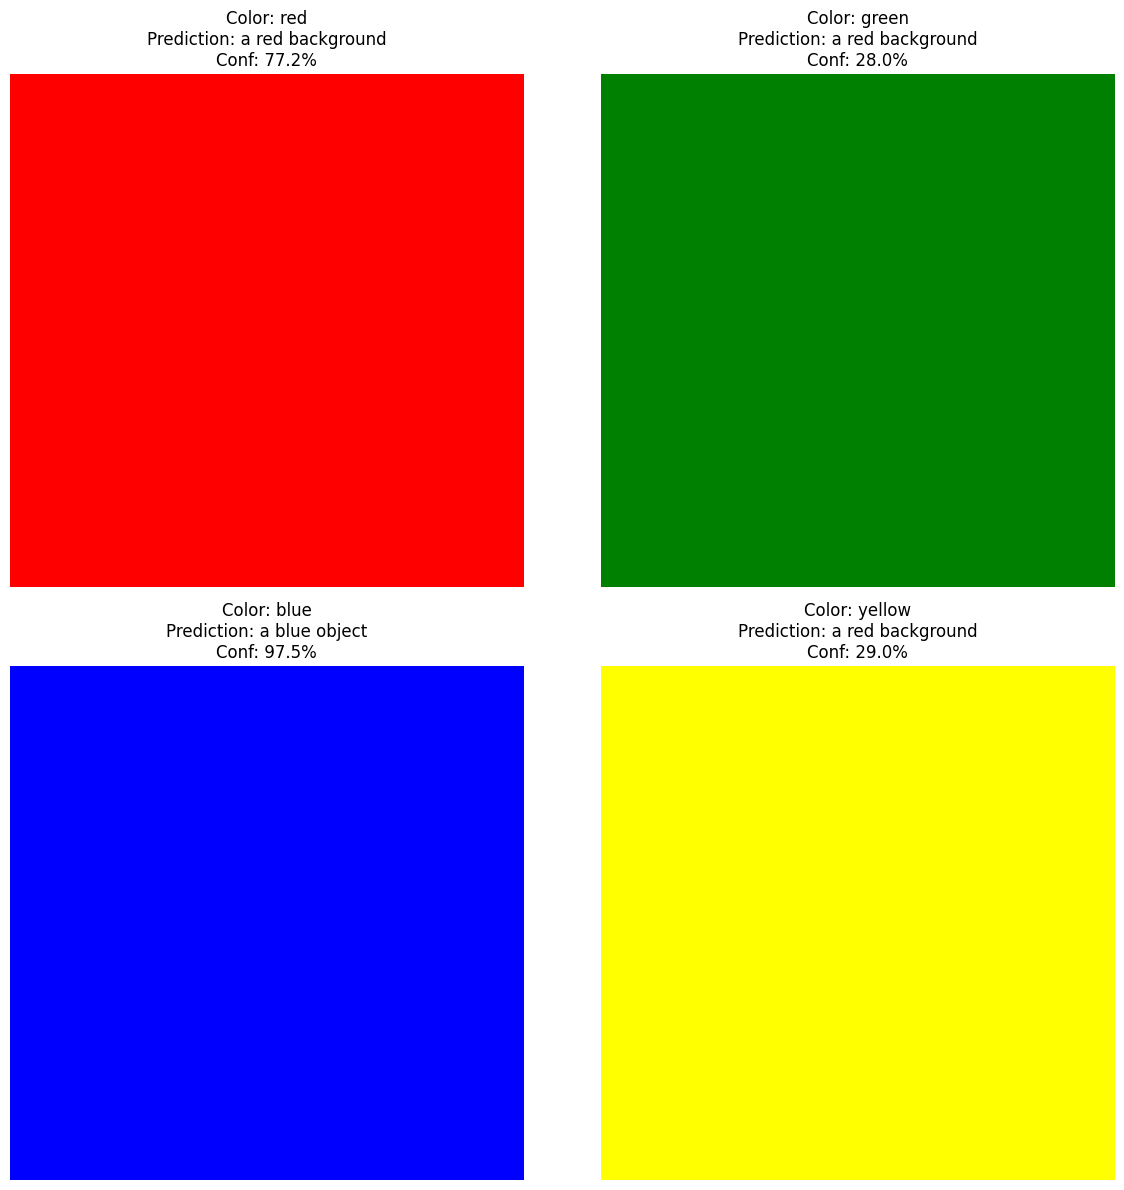

In [10]:
# Test with multiple colors to show zero-shot flexibility
colors = ['red', 'green', 'blue', 'yellow']
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for idx, color in enumerate(colors):
   # Create image of specific color
   test_image = Image.new('RGB', (100, 100), color=color)
   test_input = preprocess(test_image).unsqueeze(0).to(device)

   # Classify
   with torch.no_grad():
       image_features = model.encode_image(test_input)
       image_features /= image_features.norm(dim=-1, keepdim=True)
       similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
       value, index = similarity[0].topk(1)

   # Display
   axes[idx].imshow(test_image)
   axes[idx].set_title(f'Color: {color}\nPrediction: {text_labels[index.item()]}\nConf: {100*value.item():.1f}%')
   axes[idx].axis('off')

plt.tight_layout()
plt.show()